##Import Kaggle dataset into Google Colab

In [1]:
! pip install kaggle
!mkdir -p ~/.kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"catloy","key":"3d35752694a113cb215067f3d01e7b45"}'}

In [3]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:44<00:00, 78.8MB/s]
100% 2.29G/2.29G [00:44<00:00, 55.5MB/s]


In [5]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: ches

In [8]:
import numpy as np # forlinear algebra
import pandas as pd
import matplotlib.pyplot as plt #for plotting things
import os
import pathlib
# print(os.listdir("../input"))

from glob import glob
from PIL import Image

import cv2
import fnmatch

from time import sleep
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input,Activation, Dense, Flatten, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

##Preprocessing Steps

PNEUMONIA


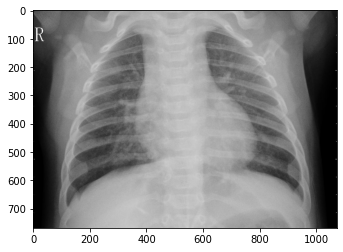

In [11]:
train_path = 'chest_xray/train/'
img_name = 'person1000_virus_1681.jpeg'
img_pneumonia = image.load_img(train_path+"PNEUMONIA/" + img_name)

print('PNEUMONIA')
plt.imshow(img_pneumonia)
plt.show()

NORMAL


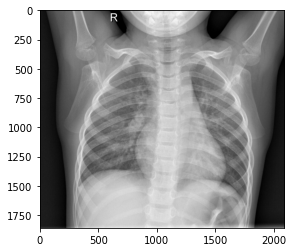

In [12]:
img_name = 'IM-0115-0001.jpeg'
img_normal = image.load_img(train_path+"NORMAL/" + img_name)

print('NORMAL')
plt.imshow(img_normal)
plt.show()

In [7]:
# combine all images 
allImages = glob('chest_xray/chest_xray/**/**/*.jpeg', recursive=True)
print(len(allImages))

17568


In [ ]:
# create images numpy array and labels numpy array
pattern_normal = '*NORMAL*'
pattern_bacteria = '*_bacteria_*'
pattern_virus = '*_virus_*'

normal = fnmatch.filter(allImages, pattern_normal)
bacteria = fnmatch.filter(allImages, pattern_bacteria)
virus = fnmatch.filter(allImages, pattern_virus)

images = []
labels = []

for img in allImages:
  image = cv2.imread(img)
  resize_image = cv2.resize(image, (200, 200), interpolation=cv2.INTER_CUBIC)
  images.append(resize_image)

  if img in normal:
    labels.append(0)
  elif img in bacteria:
    labels.append(1)
  elif img in virus:
    labels.append(1)
  else:
    print("none")

images = np.array(images)
labels = np.array(labels)

In [ ]:
# get train and validation sets
from sklearn.model_selection import train_test_split
train_images, valid_images, train_labels, valid_labels = train_test_split(images, labels, test_size = 0.2, random_state = 101)

In [ ]:
print(train_labels)

[1 1 1 ... 0 1 1]


## Create and Train Model

In [ ]:
# Create model using ResNet50
i = Input(shape=(200, 200, 3))
pretrained_model = ResNet50(input_tensor= i, include_top=False, pooling = "average")

x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(pretrained_model.input,x)
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
model.summary()

94773248/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
_____________________________

In [ ]:
# Train the model for 40 epochs
r = model.fit(
    train_images,
    train_labels,
    batch_size = 32, 
    epochs = 40,
    verbose = 1, 
    validation_split=0.2
)

Epoch 1/40
352/352 [==============================] - 58s 164ms/step - loss: 0.1540 - accuracy: 0.9486 - val_loss: 0.1714 - val_accuracy: 0.9253
Epoch 2/40
352/352 [==============================] - 56s 160ms/step - loss: 0.0844 - accuracy: 0.9706 - val_loss: 0.3673 - val_accuracy: 0.8694
Epoch 3/40
352/352 [==============================] - 56s 160ms/step - loss: 0.0584 - accuracy: 0.9779 - val_loss: 0.4392 - val_accuracy: 0.8783
Epoch 4/40
352/352 [==============================] - 56s 160ms/step - loss: 0.0418 - accuracy: 0.9844 - val_loss: 0.6585 - val_accuracy: 0.8517
Epoch 5/40
352/352 [==============================] - 56s 160ms/step - loss: 0.0363 - accuracy: 0.9874 - val_loss: 0.5702 - val_accuracy: 0.8132
Epoch 6/40
352/352 [==============================] - 56s 160ms/step - loss: 0.0336 - accuracy: 0.9885 - val_loss: 0.5138 - val_accuracy: 0.8919
Epoch 7/40
352/352 [==============================] - 56s 160ms/step - loss: 0.0293 - accuracy: 0.9889 - val_loss: 0.1273 - val_ac

## Analyse the Results

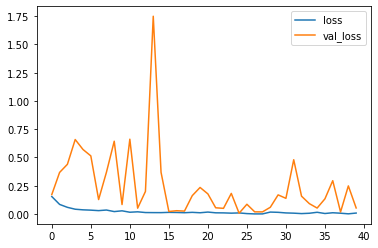

In [ ]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

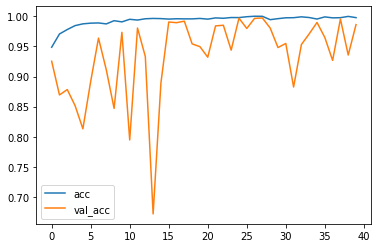

In [ ]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [ ]:
score, acc = model.evaluate(valid_images, valid_labels, batch_size=32)
print("Test loss:", score)
print("Test accuracy:", acc)

110/110 [==============================] - 5s 46ms/step - loss: 0.0575 - accuracy: 0.9849
Test loss: 0.057483166456222534
Test accuracy: 0.9849174618721008


In [ ]:
save_path = "Resnet50.h5"
model.save(save_path)

In [ ]:
import seaborn as sn

from sklearn.metrics import confusion_matrix, classification_report

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def predict(model, x, y, batch_size, model_name):
  print("Predicting with", model_name)
  probabilities = model.predict(x, batch_size=batch_size)
  predictions = probabilities.round(decimals=0).astype(int)
  
  report = classification_report(y, predictions, target_names=["0", "1"], digits=3)
  print(report)

  cm = confusion_matrix(y, predictions)
  df_cm = pd.DataFrame(cm, index=["0", "1"], columns=["0", "1"])
  sn.heatmap(df_cm, cmap=plt.cm.Blues, annot=True, fmt="d")
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion matrix for {}".format(model_name))
  plt.show()

Predicting with Resnet50
              precision    recall  f1-score   support

           0      0.995     0.947     0.971       930
           1      0.981     0.998     0.990      2584

    accuracy                          0.985      3514
   macro avg      0.988     0.973     0.980      3514
weighted avg      0.985     0.985     0.985      3514



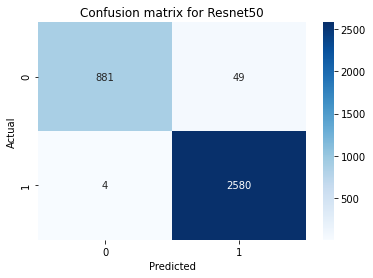

In [ ]:
predict(model, valid_images, valid_labels, 32, "Resnet50")